# Exercise A6.2

This notebook considers gradient methods for minimizing a regularized linear least-squares objective of the form
\begin{align*}
f(x) = \frac12 \|Ax-b\|_2^2 + \frac{\gamma}{2} \|x\|_2^2
\end{align*}
with variable $x \in \mathbb{R}^n$ and where $A \in \mathbb{R}^{m \times n}$, $b \in \mathbb{R}^m$, and $\gamma > 0$ are given.

Two step size rules are considered (parameterized by $\rho \in (0,2)$ with $\rho = 1$ by default):
1. Exact line search: $t_k = \rho\, \arg\min_{t>0} \,f(x_k - t \nabla f(x_k))$.
2. Constant step size $t_k = \rho/(\|A\|_2^2 + \gamma)$.

In [2]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.sparse.linalg import svds

def gdm_ls(A, b, gamma=0.0, tol=1e-3, step='exact', maxiters=500, rho=1.0, x0 = None):
    """
    Gradient descent method for least-squares problem
    """

    if x0 is not None:  
        # Initialization provided
        x = x0.copy()
        r = b - A@x        
    else:
        x = np.zeros(A.shape[1])
        r = b.copy()
    g = -A.T@r + gamma*x

    k = 0
    fval = [0.5*norm(r)**2]   # List of function values
    if step == 'exact':
        # Use exact line search
        while norm(g) > tol and k <= maxiters:
            Ag = A@g
            t = norm(g)**2 / norm(Ag)**2  # Exact line search            
            # Update r, x, and g
            r += rho*t*Ag   
            x -= rho*t*g    
            g = -A.T@r + gamma*x    
            # Compute the function value       
            fval.append(0.5*norm(r)**2 + 0.5*gamma*norm(x)**2)
            k+=1

    elif step == 'const':
        # Use constant step size t = rho/(gamma+||A||^2)
        anrmA = svds(A, k=1, return_singular_vectors=False)[0] 
        t = rho/(gamma+anrmA**2)
        while norm(g) > tol and k <= maxiters:
            x = x - t*g            
            r = b-A@x
            g = -A.T@r + gamma*x
            # Compute the function value       
            fval.append(0.5*norm(r)**2 + 0.5*gamma*norm(x)**2)
            k+=1
    else:
        raise ValueError('Invalid step size rule')
 
    status = 0 if k <= maxiters else 1
    return x, fval, status

In [3]:
# Load data from file
data = loadmat('regls.mat')
A = data['A']
b = data['b'].ravel()
gamma = data['gamma'].ravel()[0]
pstar = data['pstar'].ravel()[0]

# Run the gradient descent method with exact line search
x1,fval1,status1 = gdm_ls(A, b, gamma = gamma, step='exact')

# Run the gradient descent method with exact line search and rho = 0.6
x1r,fval1r,status1r = gdm_ls(A, b, gamma = gamma, step='exact',rho=0.6)

# Run the gradient descent method with constant step size
x2,fval2,status2 = gdm_ls(A, b, gamma = gamma, step='const')   

# Run the gradient descent method with constant step size (rho = 1.95)
x2r,fval2r,status2r = gdm_ls(A, b, gamma = gamma, step='const', rho=1.95)

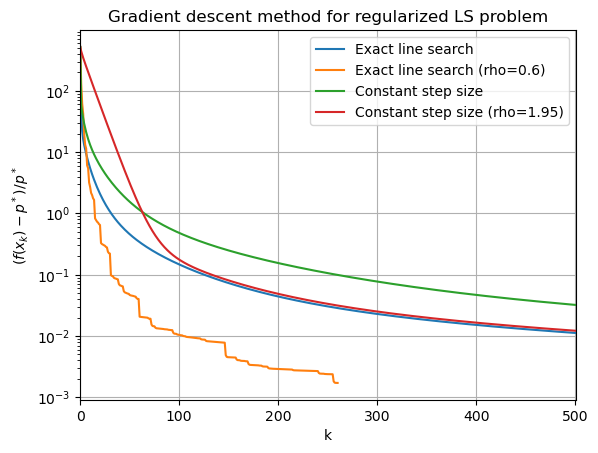

In [4]:
# Plot the relative suboptimality gap
plt.figure()
plt.semilogy(range(len(fval1)),(fval1-pstar)/pstar,label='Exact line search')
plt.semilogy(range(len(fval1r)),(fval1r-pstar)/pstar,label='Exact line search (rho=0.6)')
plt.semilogy(range(len(fval2)),(fval2-pstar)/pstar,label='Constant step size')
plt.semilogy(range(len(fval2r)),(fval2r-pstar)/pstar,label='Constant step size (rho=1.95)')
plt.title('Gradient descent method for regularized LS problem')
plt.xlabel('k')
plt.ylabel('$(f(x_k)-p^*)/p^*$')
plt.xlim([0,len(fval1)-1])
plt.grid()
plt.legend()